<a href="https://colab.research.google.com/github/Prathamesh-Chavan-98/LIVE-DEFOGGING-YOLOV8/blob/main/LIVE_DEFOGGING_YOLOV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/107.7 GB disk)


/content


<IPython.core.display.Javascript object>


0: 480x640 2 persons, 1 hot dog, 1 tv, 1638.8ms
Speed: 2.9ms preprocess, 1638.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2


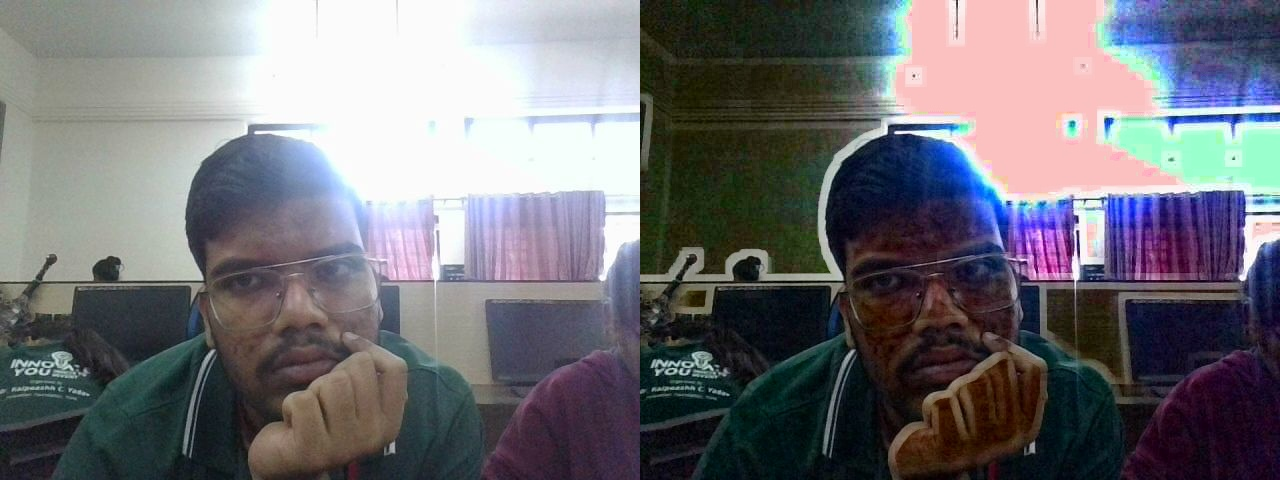

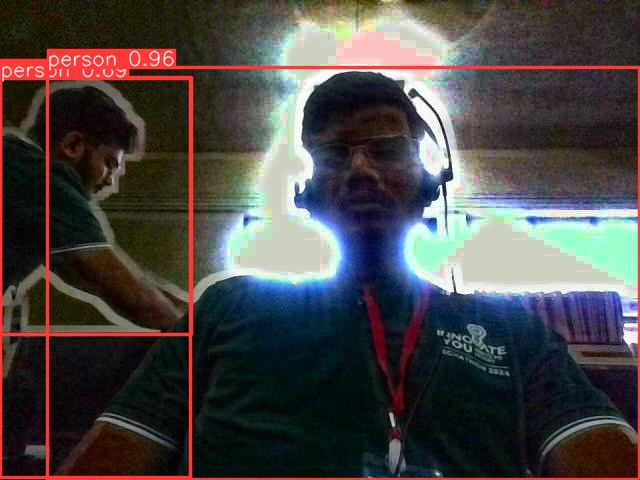

<generator object BasePredictor.stream_inference at 0x7a033fd8b300>


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

HOME = os.getcwd()
print(HOME)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import time
from ultralytics import YOLO

%cd {HOME}

model = YOLO("yolov8l.pt")

# Function for Dark Channel Prior (DCP) defogging with adjusted atmospheric light
def apply_dcp(image, window_size=15, omega=0.95, epsilon=0.001):
    min_channel = cv2.erode(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.ones((window_size, window_size), np.uint8))
    atmospheric_light = np.percentile(image.reshape(-1, 3), 99, axis=0)  # Adjusted atmospheric light estimation
    transmission = 1 - omega * min_channel / atmospheric_light.max()
    scene_radiance = np.zeros_like(image, dtype=np.float64)
    for i in range(3):
        scene_radiance[:, :, i] = ((image[:, :, i].astype(np.float64) - atmospheric_light[i]) / np.maximum(transmission, epsilon)) + atmospheric_light[i]
    scene_radiance = np.uint8(np.clip(scene_radiance, 0, 255))
    return scene_radiance

def detect_objects(image):
     results = model.predict(source=image, stream=True,save=True)
     for r in results:
        boxes = r.boxes
        masks = r.masks
        probs = r.probs
     return results

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    try:
        while True:
            # Capture a frame
            data = eval_js('takePhoto({})'.format(quality))
            binary = b64decode(data.split(',')[1])

            # Convert the image data to a NumPy array
            img_array = np.frombuffer(binary, dtype=np.uint8)

            # Decode the NumPy array into an OpenCV image
            frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

            # Apply Dark Channel Prior (DCP) for defogging with adjusted atmospheric light
            defogged_frame = apply_dcp(frame)

            detected_frame = detect_objects(defogged_frame)

            # Display the original and defogged frames
            _, img_encoded = cv2.imencode('.jpeg', np.hstack([frame, defogged_frame]))
            img_bytes = img_encoded.tobytes()
            display(Image(data=img_bytes))
            display(Image(filename='runs/detect/predict/image0.jpg', height=600))
            print(detected_frame)

            # Delay for 1 second
            time.sleep(1)
    except KeyboardInterrupt:
        pass

take_photo()
